# Rolling Window Analysis: PRE to POST Decision Period

This notebook analyzes how model performance changes as we incrementally expand the analysis window from the PRE-decision period into the POST-decision period.

**Analysis Strategy:**
1. Start with PRE-decision window: -2.0 to 0.0s (decision submission)
2. Incrementally expand into POST-decision period: 0.0s → 0.2s → 0.4s → ... → 2.0s
3. For each window, measure model accuracy and modality contributions
4. Visualize how performance evolves as we gain insight into post-decision physiology

**Research Question:** Does incorporating post-decision physiological data improve prediction accuracy?

In [1]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import project utilities
from src.utils.io import save_results
from src.utils.config import get_model_params
from src.models.fusion import weighted_late_fusion
from src.visualization.plots import set_style

np.random.seed(42)
set_style('whitegrid')

print(f"\n{'='*80}")
print(f"ROLLING WINDOW ANALYSIS: PRE → POST DECISION PERIOD")
print(f"{'='*80}\n")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


ROLLING WINDOW ANALYSIS: PRE → POST DECISION PERIOD

Analysis started: 2026-01-09 13:12:18


## 1. Define Rolling Windows

We'll create overlapping windows that progressively extend from PRE into POST period.

In [2]:
# Define rolling window endpoints
# Start: PRE window (-2.0 to 0.0)
# Then expand into POST in 0.2s increments: 0.2, 0.4, 0.6, ..., 2.0

PRE_START = -2.0
PRE_END = 0.0
POST_STEP = 0.2  # Increment size for POST expansion
POST_MAX = 2.0   # Maximum POST time

# Generate window endpoints
windows = []

# First window: Pure PRE-decision
windows.append({
    'name': 'PRE Only',
    'pre_start': PRE_START,
    'pre_end': PRE_END,
    'post_start': None,
    'post_end': None,
    'description': 'Baseline: PRE-decision only (-2.0 to 0.0s)'
})

# Rolling windows: PRE + increasing POST
post_endpoints = np.arange(POST_STEP, POST_MAX + POST_STEP, POST_STEP)
for post_end in post_endpoints:
    windows.append({
        'name': f'PRE+POST[0→{post_end:.1f}s]',
        'pre_start': PRE_START,
        'pre_end': PRE_END,
        'post_start': 0.0,
        'post_end': post_end,
        'description': f'PRE (-2.0 to 0.0s) + POST (0.0 to {post_end:.1f}s)'
    })

print(f"Created {len(windows)} rolling windows:")
print("\nWindow Details:")
print("-" * 80)
for i, w in enumerate(windows):
    print(f"{i+1:2d}. {w['name']:25s} | {w['description']}")
print("-" * 80)

Created 11 rolling windows:

Window Details:
--------------------------------------------------------------------------------
 1. PRE Only                  | Baseline: PRE-decision only (-2.0 to 0.0s)
 2. PRE+POST[0→0.2s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 0.2s)
 3. PRE+POST[0→0.4s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 0.4s)
 4. PRE+POST[0→0.6s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 0.6s)
 5. PRE+POST[0→0.8s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 0.8s)
 6. PRE+POST[0→1.0s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 1.0s)
 7. PRE+POST[0→1.2s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 1.2s)
 8. PRE+POST[0→1.4s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 1.4s)
 9. PRE+POST[0→1.6s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 1.6s)
10. PRE+POST[0→1.8s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 1.8s)
11. PRE+POST[0→2.0s]          | PRE (-2.0 to 0.0s) + POST (0.0 to 2.0s)
-------------------------------------------------------------------------------

## 2. Load PRE and POST Feature Data

We'll need both PRE and POST features to construct the rolling windows.

In [ ]:
# Load PRE-decision features
print("Loading PRE-decision features...")
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    pre_data = pickle.load(f)

pre_df = pre_data['merged_df']
pre_physio_cols = pre_data['physio_cols']
pre_behavior_cols = pre_data['behavior_cols']
pre_gaze_cols = pre_data['gaze_cols']

print(f"  PRE trials: {len(pre_df)}")
print(f"  PRE subjects: {pre_df['subject_id'].nunique()}")
print(f"  PRE features: {len(pre_physio_cols)} physio + {len(pre_behavior_cols)} behavior + {len(pre_gaze_cols)} gaze")

# Load POST-decision features
print("\nLoading POST-decision features...")
with open('../../data/results/features_POST/extracted_features_POST.pkl', 'rb') as f:
    post_data = pickle.load(f)

post_df = post_data['merged_df']
post_physio_cols = post_data['physio_cols']
post_behavior_cols = post_data['behavior_cols']

print(f"  POST trials: {len(post_df)}")
print(f"  POST subjects: {post_df['subject_id'].nunique()}")
print(f"  POST features: {len(post_physio_cols)} physio + {len(post_behavior_cols)} behavior (no gaze)")

# Merge PRE and POST on trial_id to ensure matching trials
print("\nMerging PRE and POST datasets...")

# Check trial overlap
pre_trial_ids = set(pre_df['trial_id'])
post_trial_ids = set(post_df['trial_id'])
common_trials = pre_trial_ids & post_trial_ids

print(f"  PRE-only trials: {len(pre_trial_ids - post_trial_ids)}")
print(f"  POST-only trials: {len(post_trial_ids - pre_trial_ids)}")
print(f"  Common trials: {len(common_trials)}")

# Merge - keep only trials with BOTH PRE and POST data
combined_df = pre_df.merge(
    post_df[['trial_id'] + post_physio_cols],
    on='trial_id',
    how='inner',
    suffixes=('', '_post_dup')  # Avoid suffix collision
)

# Verify no NaN values in POST physio columns (which would indicate missing data)
post_nan_count = combined_df[post_physio_cols].isna().sum().sum()
if post_nan_count > 0:
    print(f"  WARNING: {post_nan_count} NaN values in POST features - filtering...")
    # Keep only rows with complete POST data
    combined_df = combined_df.dropna(subset=post_physio_cols)
    print(f"  After filtering: {len(combined_df)} trials")

print(f"  Final combined trials: {len(combined_df)}")
print(f"  Final combined subjects: {combined_df['subject_id'].nunique()}")
print(f"\n✓ Feature loading complete - all trials have both PRE and POST data")

## 3. Extract Features for Each Rolling Window

For each window, we'll combine PRE and/or POST physiology features accordingly.

**Feature Strategy:**
- **Behavior & Gaze**: Always use PRE-decision features (these are decision-time features)
- **Physiology**: 
  - Window 1: PRE physiology only
  - Windows 2+: Combine PRE + POST physiology features

In [4]:
def get_features_for_window(df, window_config, 
                            pre_physio_cols, post_physio_cols, 
                            behavior_cols, gaze_cols):
    """
    Extract feature arrays for a specific rolling window.
    
    Parameters
    ----------
    df : pd.DataFrame
        Combined dataframe with PRE and POST features
    window_config : dict
        Window configuration with start/end times
    pre_physio_cols : list
        PRE physiology column names
    post_physio_cols : list
        POST physiology column names
    behavior_cols : list
        Behavior column names
    gaze_cols : list
        Gaze column names
    
    Returns
    -------
    tuple
        (X_physio, X_behavior, X_gaze, y, subjects)
    """
    # Behavior and gaze always from PRE (decision-time features)
    X_behavior = SimpleImputer(strategy='mean').fit_transform(df[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(df[gaze_cols])
    
    # Physiology: depends on window
    if window_config['post_start'] is None:
        # PRE only
        physio_cols = pre_physio_cols
    else:
        # PRE + POST combined
        physio_cols = pre_physio_cols + post_physio_cols
    
    X_physio = SimpleImputer(strategy='mean').fit_transform(df[physio_cols])
    
    y = df['outcome'].values
    subjects = df['subject_id'].values
    
    return X_physio, X_behavior, X_gaze, y, subjects

print("Feature extraction function defined.")

Feature extraction function defined.


## 4. Run Analysis for Each Window

Train weighted late fusion model for each rolling window using LOSO cross-validation.

In [5]:
# Storage for results
rolling_results = []

print(f"\n{'='*80}")
print("RUNNING ROLLING WINDOW ANALYSIS")
print(f"{'='*80}\n")

for i, window in enumerate(windows):
    print(f"\nWindow {i+1}/{len(windows)}: {window['name']}")
    print(f"  {window['description']}")
    print("-" * 80)
    
    # Get features for this window
    X_physio, X_behavior, X_gaze, y, subjects = get_features_for_window(
        combined_df, window,
        pre_physio_cols, post_physio_cols,
        pre_behavior_cols, pre_gaze_cols
    )
    
    print(f"  Feature shapes: Physio={X_physio.shape}, Behavior={X_behavior.shape}, Gaze={X_gaze.shape}")
    
    # Prepare modality list
    X_modalities = [X_physio, X_behavior, X_gaze]
    modality_names = ['Physiology', 'Behavior', 'Gaze']
    
    # Run weighted late fusion
    try:
        results = weighted_late_fusion(
            X_modalities, y, subjects, modality_names,
            fusion_method='weighted'
        )
        
        # Extract results
        window_result = {
            'window_id': i,
            'window_name': window['name'],
            'post_end_time': window['post_end'] if window['post_end'] is not None else 0.0,
            'accuracy': results['accuracy_mean'],
            'accuracy_sem': results['accuracy_sem'],
            'accuracy_std': results['accuracy_std'],
            'f1_score': results['f1_mean'],
            'f1_sem': results['f1_sem'],
            'physio_weight': results['weights'][0],
            'behavior_weight': results['weights'][1],
            'gaze_weight': results['weights'][2],
            'n_subjects': results['n_subjects'],
            'n_trials': results['n_trials'],
            'n_physio_features': X_physio.shape[1],
            'invest_ratio': np.mean(y)
        }
        
        rolling_results.append(window_result)
        
        print(f"  ✓ Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_sem']:.4f}")
        print(f"    F1-Score: {results['f1_mean']:.4f} ± {results['f1_sem']:.4f}")
        print(f"    Weights: Physio={results['weights'][0]:.3f}, Behavior={results['weights'][1]:.3f}, Gaze={results['weights'][2]:.3f}")
        
    except Exception as e:
        print(f"  ✗ Error: {e}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(rolling_results)

print(f"\n{'='*80}")
print(f"✓ Analysis complete: {len(results_df)} windows analyzed")
print(f"{'='*80}")


RUNNING ROLLING WINDOW ANALYSIS


Window 1/11: PRE Only
  Baseline: PRE-decision only (-2.0 to 0.0s)
--------------------------------------------------------------------------------
  Feature shapes: Physio=(12511, 13), Behavior=(12511, 7), Gaze=(12511, 20)
  ✓ Accuracy: 0.6931 ± 0.0133
    F1-Score: 0.6794 ± 0.0157
    Weights: Physio=0.031, Behavior=0.967, Gaze=0.002

Window 2/11: PRE+POST[0→0.2s]
  PRE (-2.0 to 0.0s) + POST (0.0 to 0.2s)
--------------------------------------------------------------------------------
  Feature shapes: Physio=(12511, 26), Behavior=(12511, 7), Gaze=(12511, 20)
  ✓ Accuracy: 0.6929 ± 0.0134
    F1-Score: 0.6794 ± 0.0157
    Weights: Physio=0.036, Behavior=0.962, Gaze=0.002

Window 3/11: PRE+POST[0→0.4s]
  PRE (-2.0 to 0.0s) + POST (0.0 to 0.4s)
--------------------------------------------------------------------------------
  Feature shapes: Physio=(12511, 26), Behavior=(12511, 7), Gaze=(12511, 20)
  ✓ Accuracy: 0.6929 ± 0.0134
    F1-Score: 0.6794 ± 

## 5. Visualize Results

Plot how accuracy and modality weights change across the rolling windows.

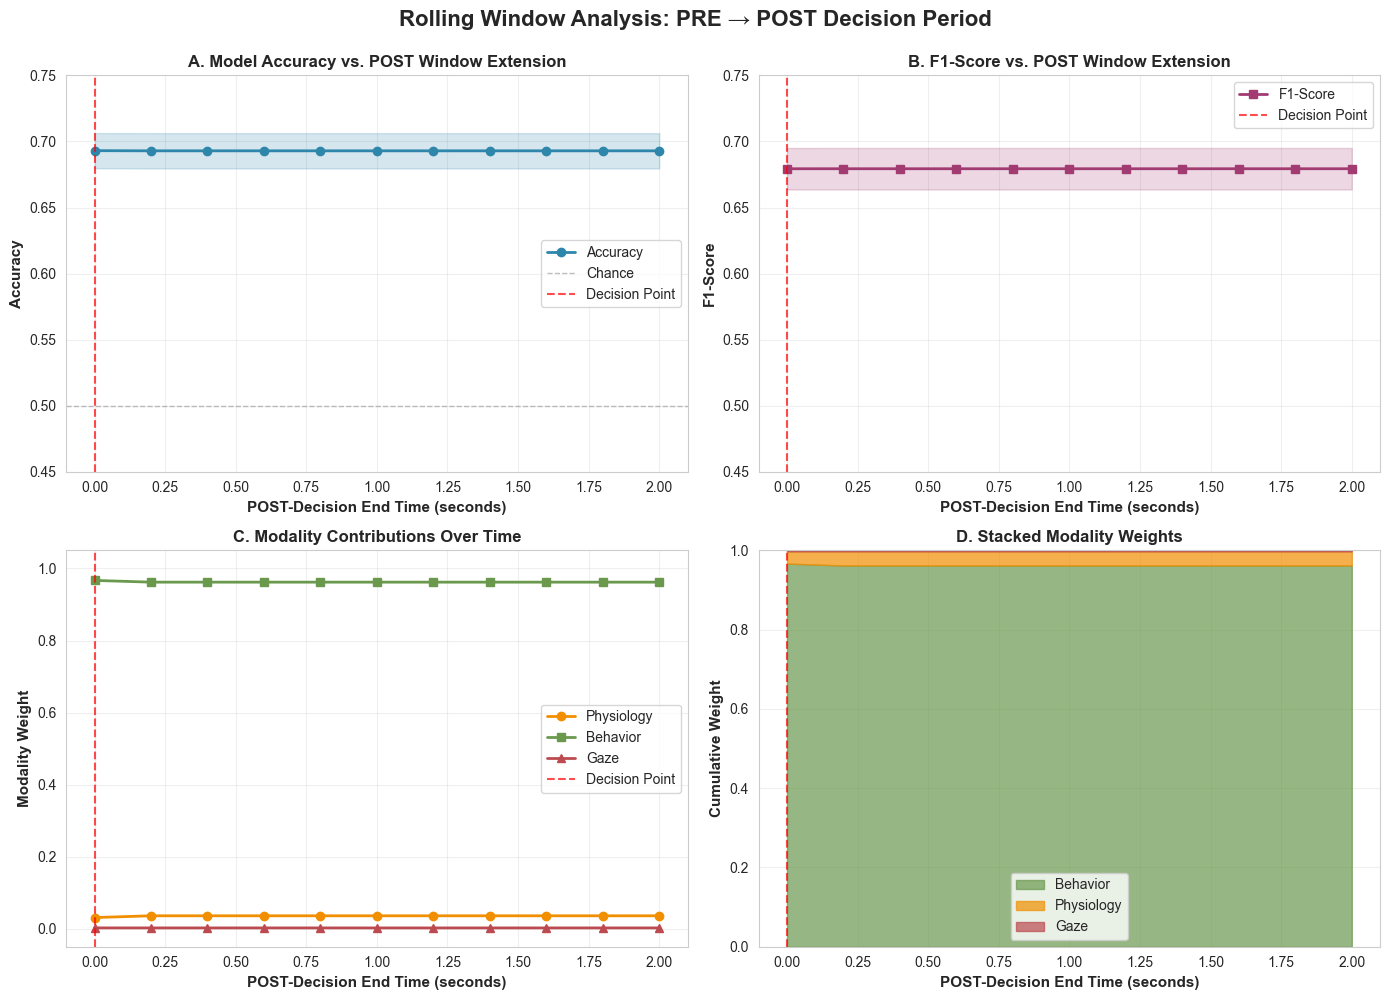


✓ Visualization complete


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Rolling Window Analysis: PRE → POST Decision Period', 
             fontsize=16, fontweight='bold', y=0.995)

# Subplot 1: Accuracy over time
ax1 = axes[0, 0]
ax1.plot(results_df['post_end_time'], results_df['accuracy'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB', label='Accuracy')
ax1.fill_between(results_df['post_end_time'],
                  results_df['accuracy'] - results_df['accuracy_sem'],
                  results_df['accuracy'] + results_df['accuracy_sem'],
                  alpha=0.2, color='#2E86AB')
ax1.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Chance')
ax1.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax1.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('A. Model Accuracy vs. POST Window Extension', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.45, 0.75])

# Subplot 2: F1-Score over time
ax2 = axes[0, 1]
ax2.plot(results_df['post_end_time'], results_df['f1_score'], 
         marker='s', linewidth=2, markersize=6, color='#A23B72', label='F1-Score')
ax2.fill_between(results_df['post_end_time'],
                  results_df['f1_score'] - results_df['f1_sem'],
                  results_df['f1_score'] + results_df['f1_sem'],
                  alpha=0.2, color='#A23B72')
ax2.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax2.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('B. F1-Score vs. POST Window Extension', fontsize=12, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.45, 0.75])

# Subplot 3: Modality weights over time
ax3 = axes[1, 0]
ax3.plot(results_df['post_end_time'], results_df['physio_weight'], 
         marker='o', linewidth=2, markersize=6, label='Physiology', color='#F18F01')
ax3.plot(results_df['post_end_time'], results_df['behavior_weight'], 
         marker='s', linewidth=2, markersize=6, label='Behavior', color='#6A994E')
ax3.plot(results_df['post_end_time'], results_df['gaze_weight'], 
         marker='^', linewidth=2, markersize=6, label='Gaze', color='#BC4B51')
ax3.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Decision Point')
ax3.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Modality Weight', fontsize=11, fontweight='bold')
ax3.set_title('C. Modality Contributions Over Time', fontsize=12, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-0.05, 1.05])

# Subplot 4: Stacked area chart of modality weights
ax4 = axes[1, 1]
ax4.fill_between(results_df['post_end_time'], 0, results_df['behavior_weight'],
                  label='Behavior', color='#6A994E', alpha=0.7)
ax4.fill_between(results_df['post_end_time'], 
                  results_df['behavior_weight'],
                  results_df['behavior_weight'] + results_df['physio_weight'],
                  label='Physiology', color='#F18F01', alpha=0.7)
ax4.fill_between(results_df['post_end_time'],
                  results_df['behavior_weight'] + results_df['physio_weight'],
                  1.0,
                  label='Gaze', color='#BC4B51', alpha=0.7)
ax4.axvline(x=0.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('POST-Decision End Time (seconds)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Cumulative Weight', fontsize=11, fontweight='bold')
ax4.set_title('D. Stacked Modality Weights', fontsize=12, fontweight='bold')
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## 6. Statistical Analysis

Test whether accuracy significantly changes across windows.

In [7]:
print(f"\n{'='*80}")
print("STATISTICAL ANALYSIS")
print(f"{'='*80}\n")

# 1. Compare PRE-only vs. best POST window
pre_only_acc = results_df.iloc[0]['accuracy']
pre_only_sem = results_df.iloc[0]['accuracy_sem']

best_idx = results_df['accuracy'].idxmax()
best_window = results_df.iloc[best_idx]
best_acc = best_window['accuracy']
best_sem = best_window['accuracy_sem']

print("1. PRE-only vs. Best POST Window:")
print(f"   PRE-only:      Accuracy = {pre_only_acc:.4f} ± {pre_only_sem:.4f}")
print(f"   Best window:   {best_window['window_name']}")
print(f"                  Accuracy = {best_acc:.4f} ± {best_sem:.4f}")
print(f"   Improvement:   {(best_acc - pre_only_acc):.4f} ({100*(best_acc - pre_only_acc)/pre_only_acc:.2f}%)")

# 2. Trend analysis: Is there a significant linear trend?
from scipy.stats import pearsonr, spearmanr

# Remove first point (PRE-only at x=0) for POST-only trend
post_times = results_df['post_end_time'].values[1:]
post_accs = results_df['accuracy'].values[1:]

pearson_r, pearson_p = pearsonr(post_times, post_accs)
spearman_r, spearman_p = spearmanr(post_times, post_accs)

print(f"\n2. Trend Analysis (POST windows only):")
print(f"   Pearson correlation:  r = {pearson_r:.4f}, p = {pearson_p:.4f}")
print(f"   Spearman correlation: ρ = {spearman_r:.4f}, p = {spearman_p:.4f}")

if pearson_p < 0.05:
    trend_direction = "positive" if pearson_r > 0 else "negative"
    print(f"   ✓ Significant {trend_direction} trend detected (p < 0.05)")
else:
    print(f"   ✗ No significant linear trend (p ≥ 0.05)")

# 3. Summary statistics
print(f"\n3. Summary Statistics Across All Windows:")
print(f"   Mean accuracy:     {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"   Min accuracy:      {results_df['accuracy'].min():.4f} (Window: {results_df.loc[results_df['accuracy'].idxmin(), 'window_name']})")
print(f"   Max accuracy:      {results_df['accuracy'].max():.4f} (Window: {results_df.loc[results_df['accuracy'].idxmax(), 'window_name']})")
print(f"   Range:             {results_df['accuracy'].max() - results_df['accuracy'].min():.4f}")

print(f"\n{'='*80}")


STATISTICAL ANALYSIS

1. PRE-only vs. Best POST Window:
   PRE-only:      Accuracy = 0.6931 ± 0.0133
   Best window:   PRE Only
                  Accuracy = 0.6931 ± 0.0133
   Improvement:   0.0000 (0.00%)

2. Trend Analysis (POST windows only):
   Pearson correlation:  r = nan, p = nan
   Spearman correlation: ρ = nan, p = nan
   ✗ No significant linear trend (p ≥ 0.05)

3. Summary Statistics Across All Windows:
   Mean accuracy:     0.6929 ± 0.0000
   Min accuracy:      0.6929 (Window: PRE+POST[0→0.2s])
   Max accuracy:      0.6931 (Window: PRE Only)
   Range:             0.0001



## 7. Summary Table

Display key results for all windows.

In [8]:
# Create summary table
summary_table = results_df[[
    'window_name', 'post_end_time', 'accuracy', 'accuracy_sem', 
    'f1_score', 'physio_weight', 'behavior_weight', 'gaze_weight',
    'n_physio_features'
]].copy()

# Format for display
summary_table['accuracy_fmt'] = summary_table.apply(
    lambda row: f"{row['accuracy']:.4f} ± {row['accuracy_sem']:.4f}", axis=1
)
summary_table['f1_fmt'] = summary_table['f1_score'].apply(lambda x: f"{x:.4f}")
summary_table['weights_fmt'] = summary_table.apply(
    lambda row: f"P:{row['physio_weight']:.2f} B:{row['behavior_weight']:.2f} G:{row['gaze_weight']:.2f}",
    axis=1
)

display_table = summary_table[[
    'window_name', 'post_end_time', 'accuracy_fmt', 'f1_fmt', 'weights_fmt', 'n_physio_features'
]].rename(columns={
    'window_name': 'Window',
    'post_end_time': 'POST End (s)',
    'accuracy_fmt': 'Accuracy (±SEM)',
    'f1_fmt': 'F1-Score',
    'weights_fmt': 'Modality Weights',
    'n_physio_features': 'Physio Features'
})

print(f"\n{'='*120}")
print("ROLLING WINDOW RESULTS SUMMARY")
print(f"{'='*120}")
print(display_table.to_string(index=False))
print(f"{'='*120}")


ROLLING WINDOW RESULTS SUMMARY
          Window  POST End (s) Accuracy (±SEM) F1-Score     Modality Weights  Physio Features
        PRE Only           0.0 0.6931 ± 0.0133   0.6794 P:0.03 B:0.97 G:0.00               13
PRE+POST[0→0.2s]           0.2 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→0.4s]           0.4 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→0.6s]           0.6 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→0.8s]           0.8 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→1.0s]           1.0 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→1.2s]           1.2 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→1.4s]           1.4 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→1.6s]           1.6 0.6929 ± 0.0134   0.6794 P:0.04 B:0.96 G:0.00               26
PRE+POST[0→1.8s]           1

## 8. Save Results

Export results to CSV for further analysis.

In [9]:
# Save results
output_dir = Path('../../data/results/analysis_outputs_PRE')
output_dir.mkdir(parents=True, exist_ok=True)

output_file = output_dir / 'rolling_window_post_decision_analysis.csv'
save_results(results_df, str(output_file))

print(f"\n✓ Results saved to: {output_file}")
print(f"  Rows: {len(results_df)}")
print(f"  Columns: {len(results_df.columns)}")

# Also save summary table
summary_file = output_dir / 'rolling_window_post_decision_summary.csv'
save_results(display_table, str(summary_file))
print(f"\n✓ Summary table saved to: {summary_file}")

print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"Analysis finished: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Saved results to: ../../data/results/analysis_outputs_PRE/rolling_window_post_decision_analysis.csv

✓ Results saved to: ../../data/results/analysis_outputs_PRE/rolling_window_post_decision_analysis.csv
  Rows: 11
  Columns: 15
✓ Saved results to: ../../data/results/analysis_outputs_PRE/rolling_window_post_decision_summary.csv

✓ Summary table saved to: ../../data/results/analysis_outputs_PRE/rolling_window_post_decision_summary.csv

ANALYSIS COMPLETE
Analysis finished: 2026-01-09 15:06:54
